# PyDMD

## User Manual 1: BOP-DMD on Flow Past a Cylinder Data

In this guide, we briefly highlight all of the major features of the `BOPDMD`[[docs]](https://pydmd.github.io/PyDMD/bopdmd.html)[[source]](https://github.com/PyDMD/PyDMD/blob/master/pydmd/bopdmd.py) module by applying it to 2-D flow past a cylinder vorticity data with Reynolds number $Re = 100$. Examples listed in the table of contents will consecutively build on one another so that sample models will slowly increase in complexity. Data is available at <ins>dmdbook.com/DATA.zip</ins>. Note that we use a low resolution version of the data in this guide.

#### Table of Contents:
1. [Optimized DMD](#optdmd)
2. [Optimized DMD with Bagging (BOP-DMD)](#bopdmd)
3. [Parallelized Bagging](#parallel-bopdmd)
4. [BOP-DMD with Eigenvalue Constraints](#eig)
5. [Using Verbose Outputs](#verbose)
6. [Removing Bad Bags](#bag-fail)
7. [Applying Data Preprocessors](#preprocess)

### Import the Latest Version of PyDMD
To ensure that you are working with the most up-to-date version of PyDMD, clone the repository with
```bash
git clone https://github.com/PyDMD/PyDMD
```
and pip install the package in development mode from the cloned directory.
```bash
pip install -e .
```
We may then perform our imports and be certain to have access to the latest PyDMD features.

In [1]:
import dask
import warnings
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from pydmd import BOPDMD
from pydmd.plotter import plot_summary
from pydmd.preprocessing import zero_mean_preprocessing

warnings.filterwarnings("ignore")

### Import the Flow Past a Cylinder Data
We have 151 snapshots, each with a pixel dimension of 149 x 66. To perform BOP-DMD, we define:
- `X` = (9834, 151) NumPy array of flattened snapshots. We add Gaussian noise for added realism.
- `t` = (151,) NumPy array of times of snapshot collection. We assume these times to be $0,1,\dots$

In [2]:
# Import vorticity data and frame dimensions.
mat = sio.loadmat("CYLINDER_ALL_LOW_RES.mat")

X = mat["VORTALL"]  # Vorticity data.
nx = mat["nx"][0][0]  # Number of pixels along x-axis.
ny = mat["ny"][0][0]  # Number of pixels along y-axis.
m = X.shape[-1]  # Number of time points.
t = np.arange(m)  # Time data.

# Add Gaussian noise to the data.
noise_magnitude = 0.4
rng = np.random.default_rng(seed=1234)
noise = noise_magnitude * rng.standard_normal(X.shape)
X += noise

print(f"Data dimensions = {X.shape} (space, time)")

Data dimensions = (9834, 151) (space, time)


### 1. Optimized DMD
<a id='optdmd'></a>
To perform [Optimized DMD](https://doi.org/10.1137/M1124176), use the `BOPDMD` module with `num_trials=0`.
- Adjust the `svd_rank` parameter to control the number of spatiotemporal modes computed.
- Fit the model with the `fit` function.
    - For the `BOPDMD` module, this function requires both the snapshots `X` and the times `t`.
- Plot results using the `plot_summary` function.
    - See plotting tool documentation [[docs]](https://pydmd.github.io/PyDMD/plotter.html) for more information on customization options.

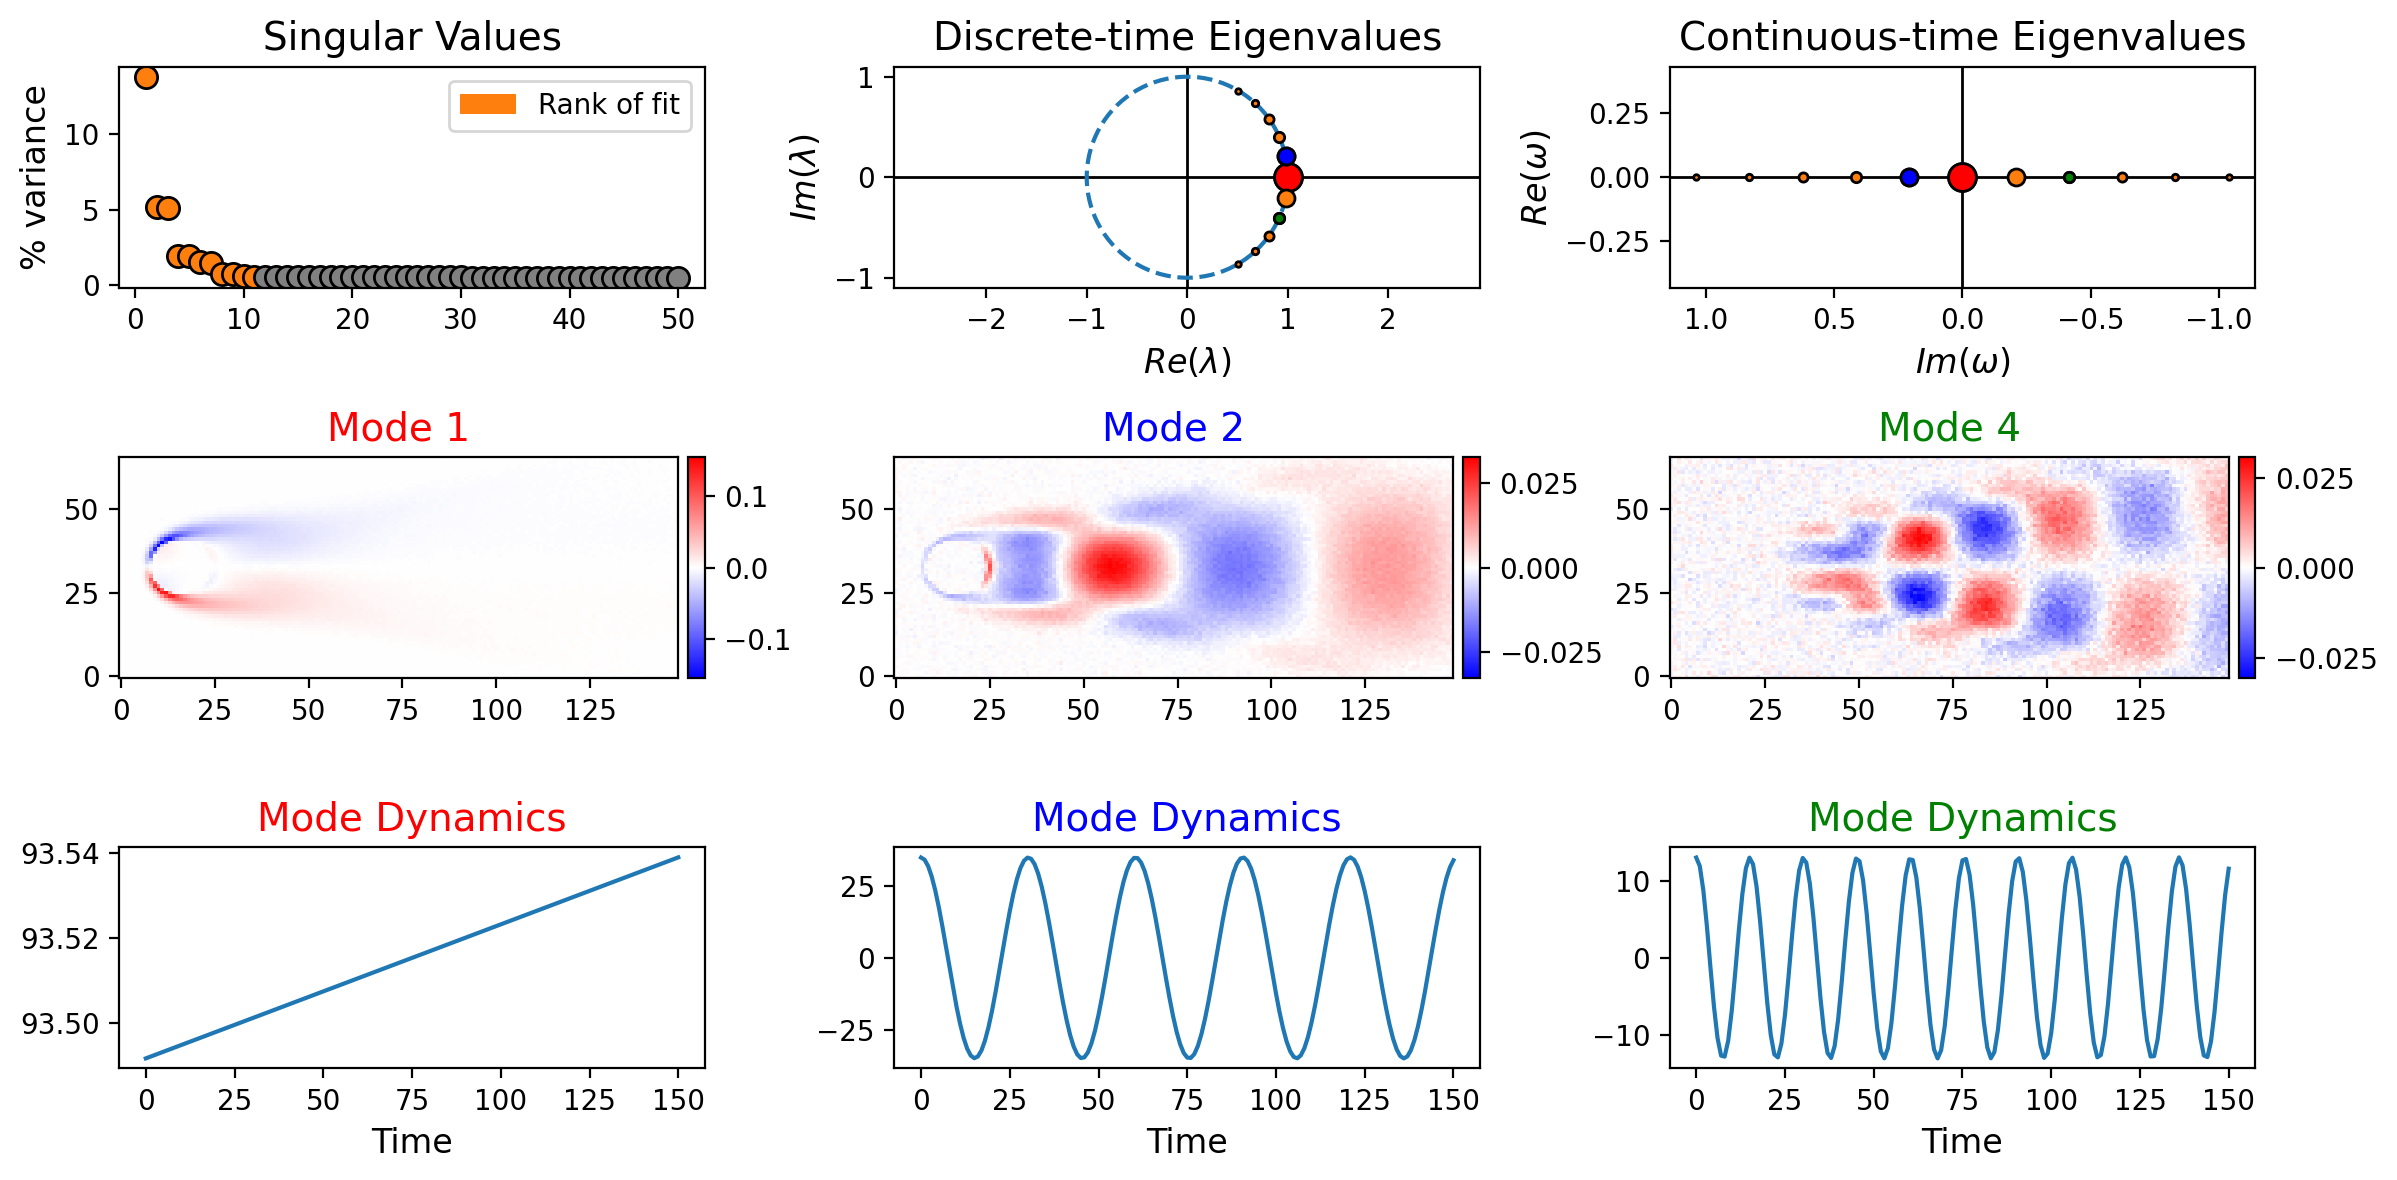

In [3]:
# Build an Optimized DMD model with 11 spatiotemporal modes.
bopdmd = BOPDMD(svd_rank=11, num_trials=0)

# Fit the Optimized DMD model.
bopdmd.fit(X, t)

# Plot a summary of the key spatiotemporal modes.
plot_summary(
    bopdmd,
    figsize=(12, 6),  # Figure size.
    index_modes=(0, 1, 3),  # Indices of the modes to plot.
    snapshots_shape=(ny, nx),  # Shape of the modes.
    order="F",  # Order to use when reshaping the modes.
    flip_continuous_axes=True,  # Rotate the continuous-time eig plot.
)

Alternatively, pre-compute the SVD and use the `fit_econ` function.
`fit_econ` is useful when the SVD is already computed and the snapshots matrix `X` is not available or is too large to store in memory.

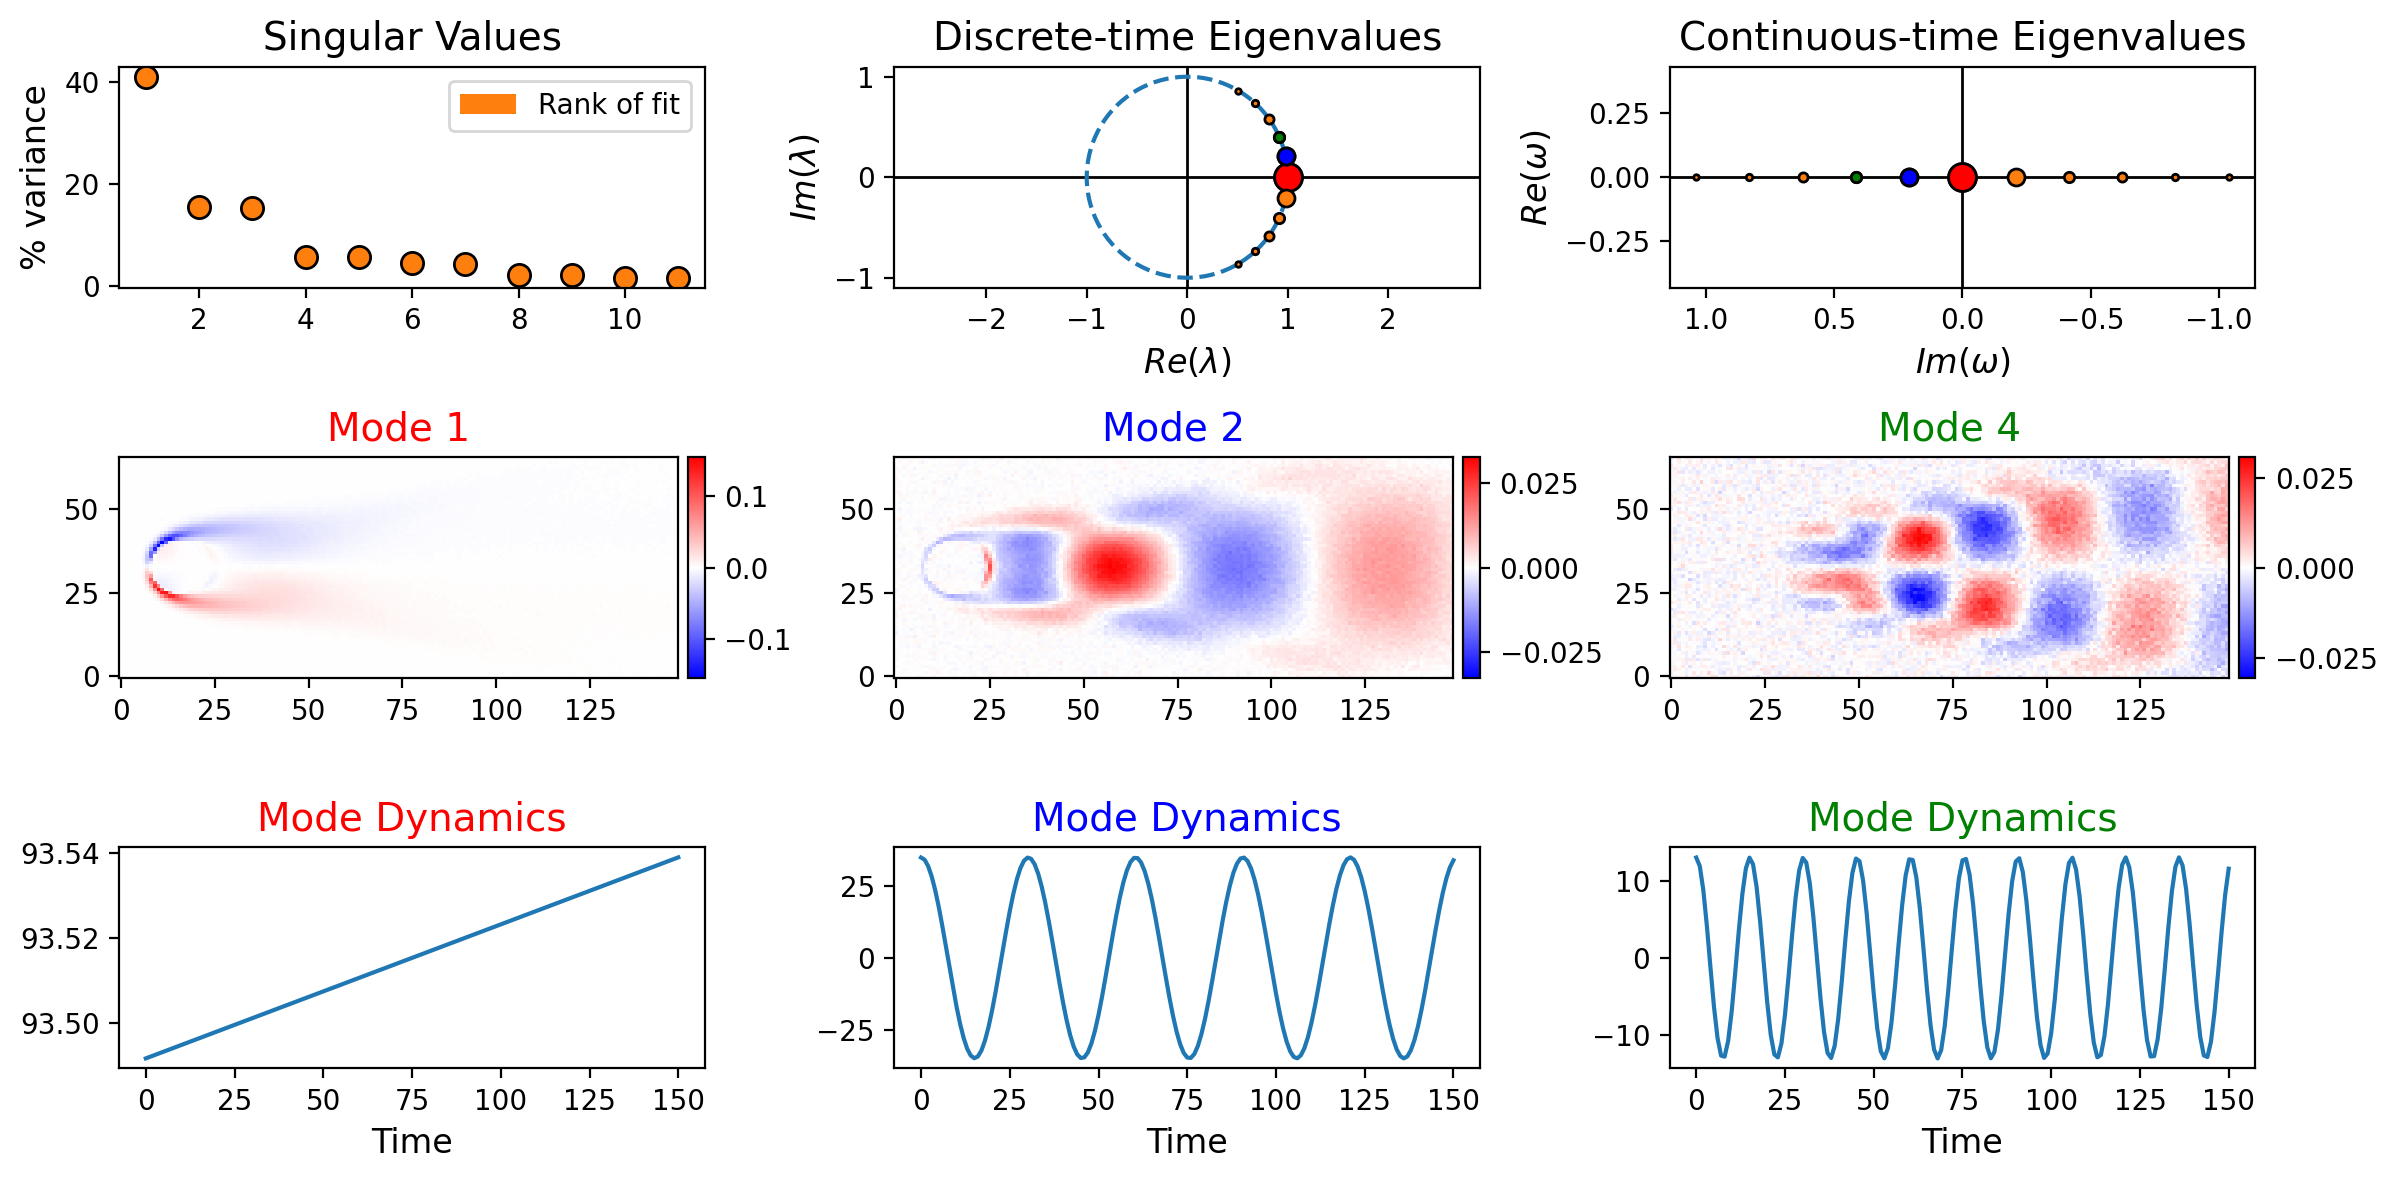

In [4]:
# Pre-compute the SVD. For a large matrix X, you could do this with a randomized SVD.
U, s, V = np.linalg.svd(X, full_matrices=False)
U = U[:, :11]
s = s[:11]
V = V[:11, :]

bopdmd_econ = BOPDMD(svd_rank=11, num_trials=0, use_proj=True, proj_basis=U)
bopdmd_econ.fit_econ(s, V, t)

plot_summary(
    bopdmd_econ,
    figsize=(12, 6),  # Figure size.
    index_modes=(0, 1, 3),  # Indices of the modes to plot.
    snapshots_shape=(ny, nx),  # Shape of the modes.
    order="F",  # Order to use when reshaping the modes.
    flip_continuous_axes=True,  # Rotate the continuous-time eig plot.
)

In [5]:
# Set the plot_summary arguments for later function calls.
plot_summary_kwargs = {}
plot_summary_kwargs["figsize"] = (12, 6)
plot_summary_kwargs["index_modes"] = (0, 1, 3)
plot_summary_kwargs["snapshots_shape"] = (ny, nx)
plot_summary_kwargs["order"] = "F"
plot_summary_kwargs["flip_continuous_axes"] = True

### 2. Optimized DMD with Bagging (BOP-DMD)
<a id='bopdmd'></a>
To perform [BOP-DMD](https://doi.org/10.1098/rsta.2021.0199), use the `BOPDMD` module with `num_trials=k` for positive integer `k`.
- Set the `trial_size` parameter to control the amount of data to use per bag.
- `plot_summary` now displays the average spatiotemporal modes across trials.
- When multiple trials are performed, UQ metrics can also be plotted:
    - Use `plot_eig_uq` for eigenvalue UQ metrics.
    - Use `plot_mode_uq` for mode UQ metrics.

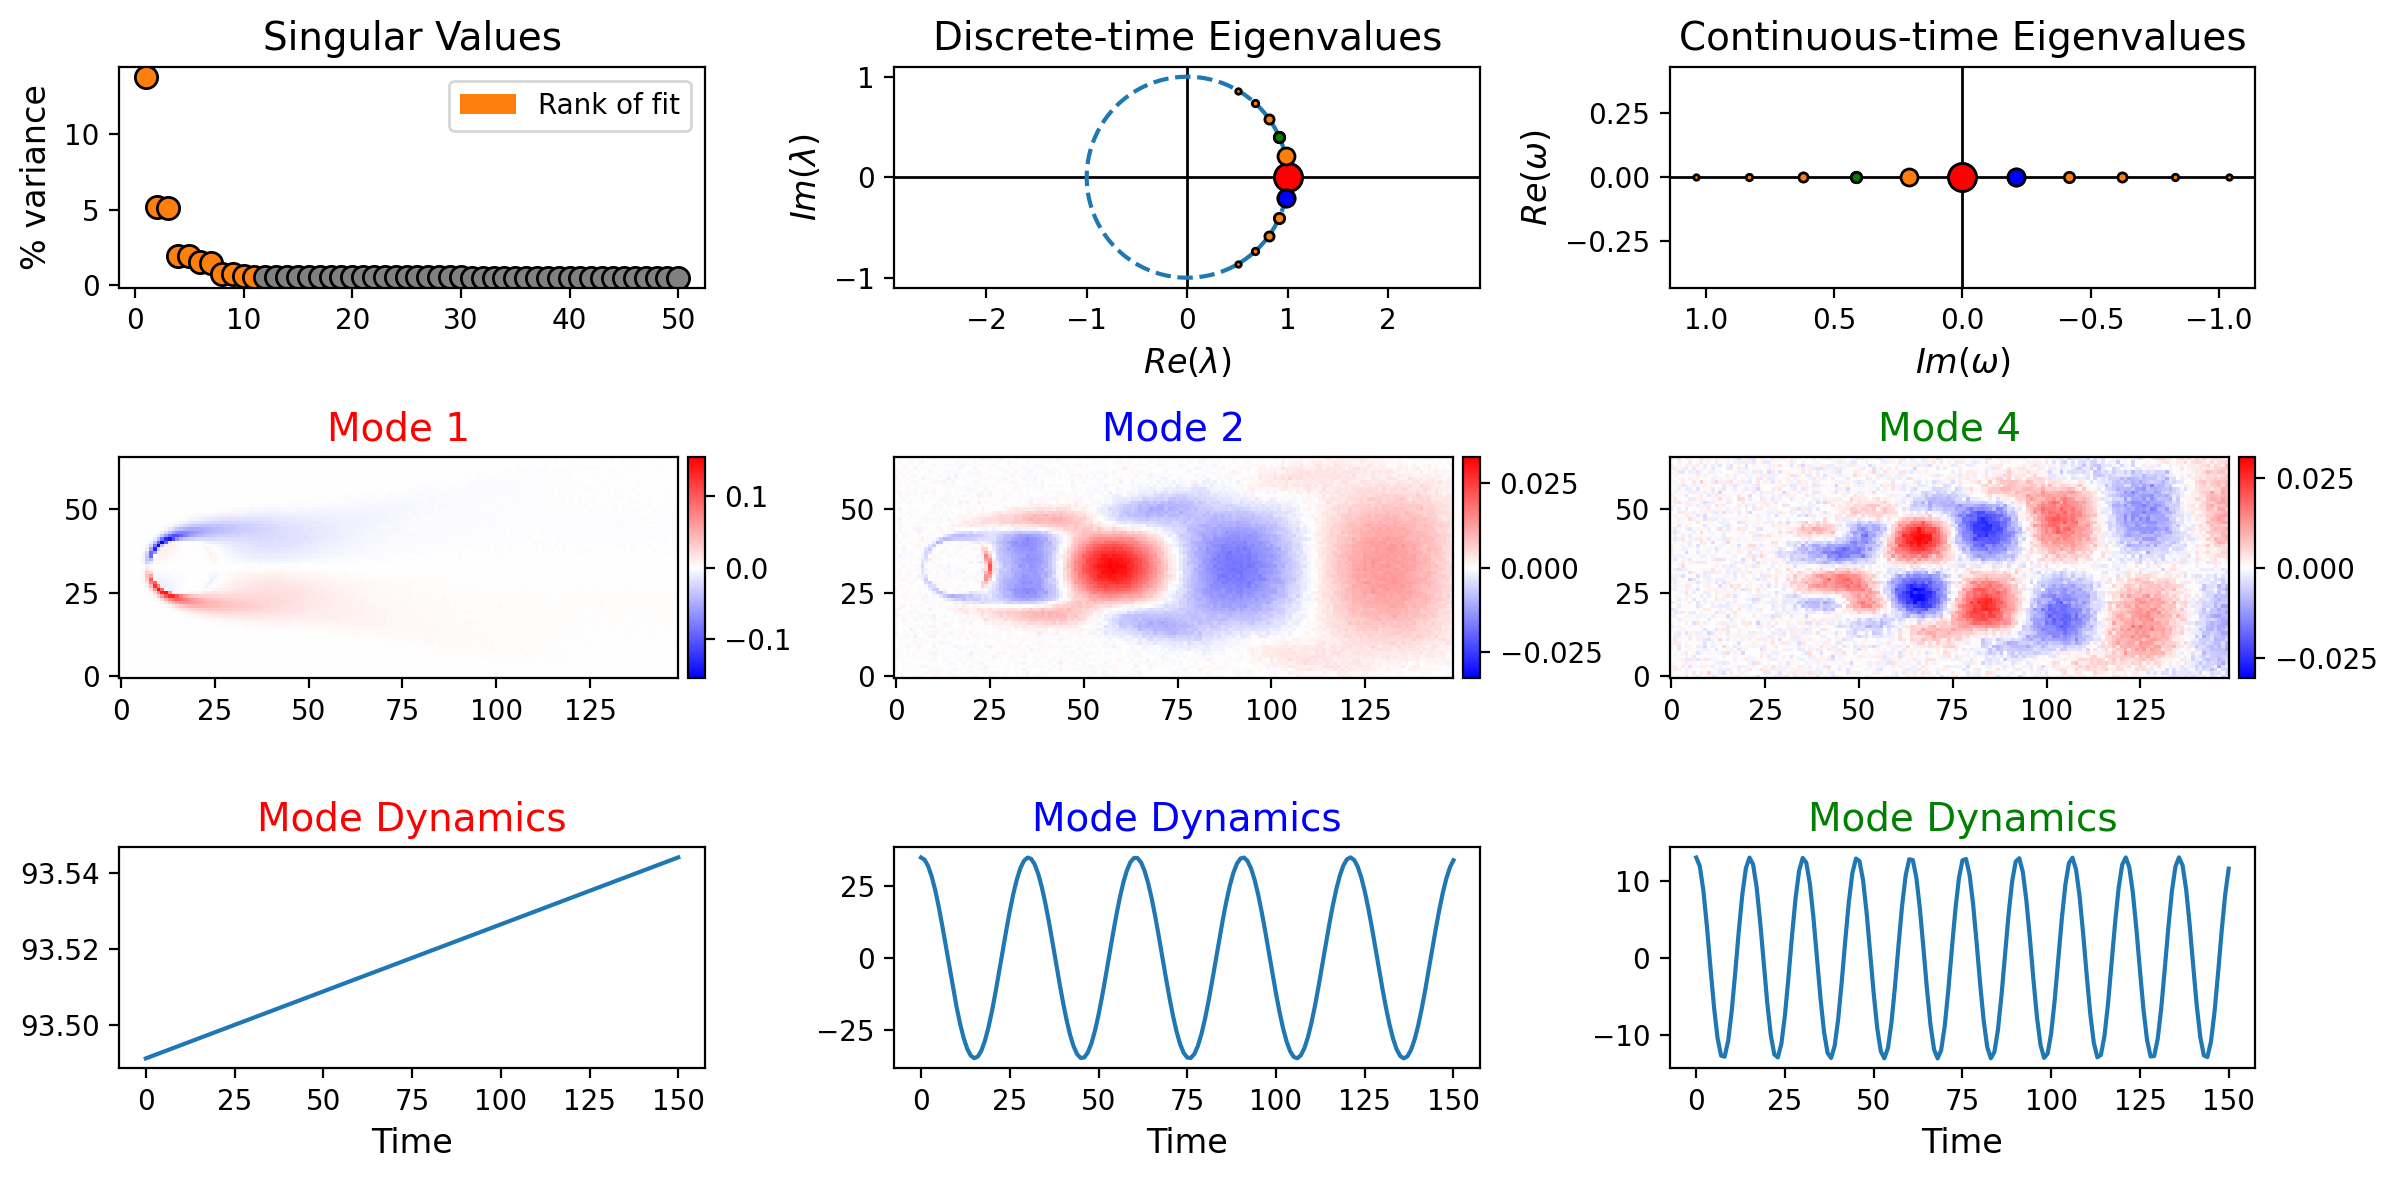

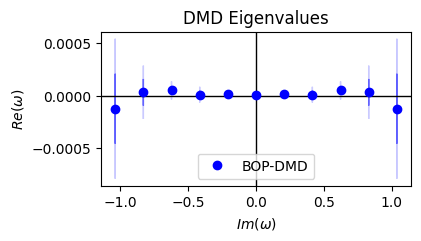

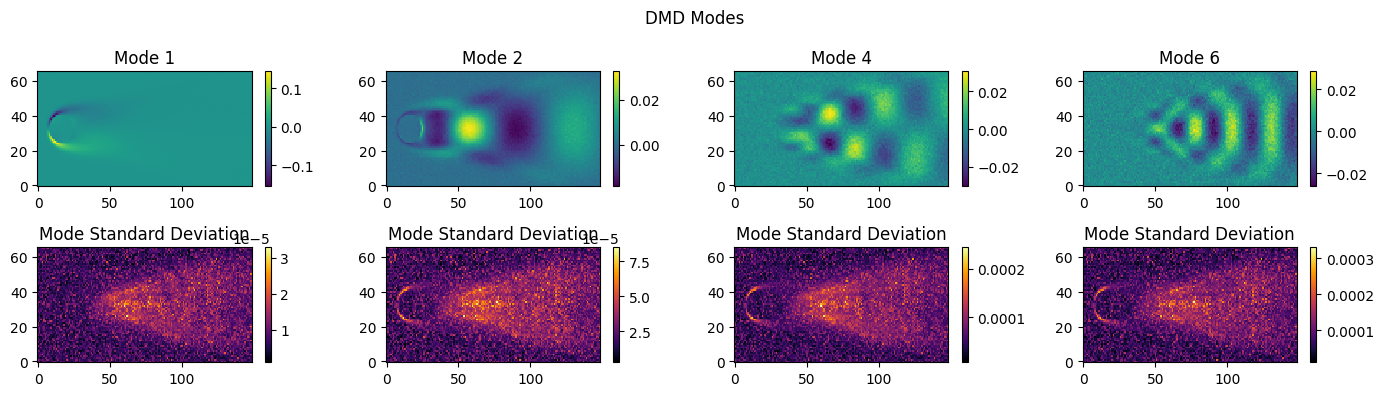

In [6]:
# Build a BOP-DMD model with 11 spatiotemporal modes, and 100 bagging trials,
# where each trial uses 80% of the total number of snapshots per trial.
# Set the seed for reproducible output.
bopdmd = BOPDMD(svd_rank=11, num_trials=100, trial_size=0.8, seed=1234)
bopdmd.fit(X, t)
plot_summary(bopdmd, **plot_summary_kwargs)

# Plot eigenvalue UQ metrics.
bopdmd.plot_eig_uq(figsize=(4, 2), flip_axes=True, draw_axes=True)

# Plot mode UQ metrics.
bopdmd.plot_mode_uq(
    figsize=(14, 4),
    plot_modes=(0, 1, 3, 5),
    modes_shape=(ny, nx),
    order="F",
)

### 3. Parallelized bagging
<a id='parallel-bopdmd'></a>
If you are working on a large dataset or using a large number of bags, you might want to run the bagging in parallel. Bagging is an embarrassingly parallel problem run in a loop where each loop iteration is independent from other iterations. The parallelization is here implemented with [Dask](https://www.dask.org/). To overcome Python's GIL, it is recommended to use Dask's multiprocessing or distributed [schedulers](https://docs.dask.org/en/stable/scheduler-overview.html). The example below shows how to call the `fit()` method using the multiprocessing scheduler. For this to work, you need to set the `parallel_bagging` flag to `True` when creating the `BOPDMD` instance.

Number of converged bags: 0 out of 100. Consider loosening the tol requirements of the variable projection routine.


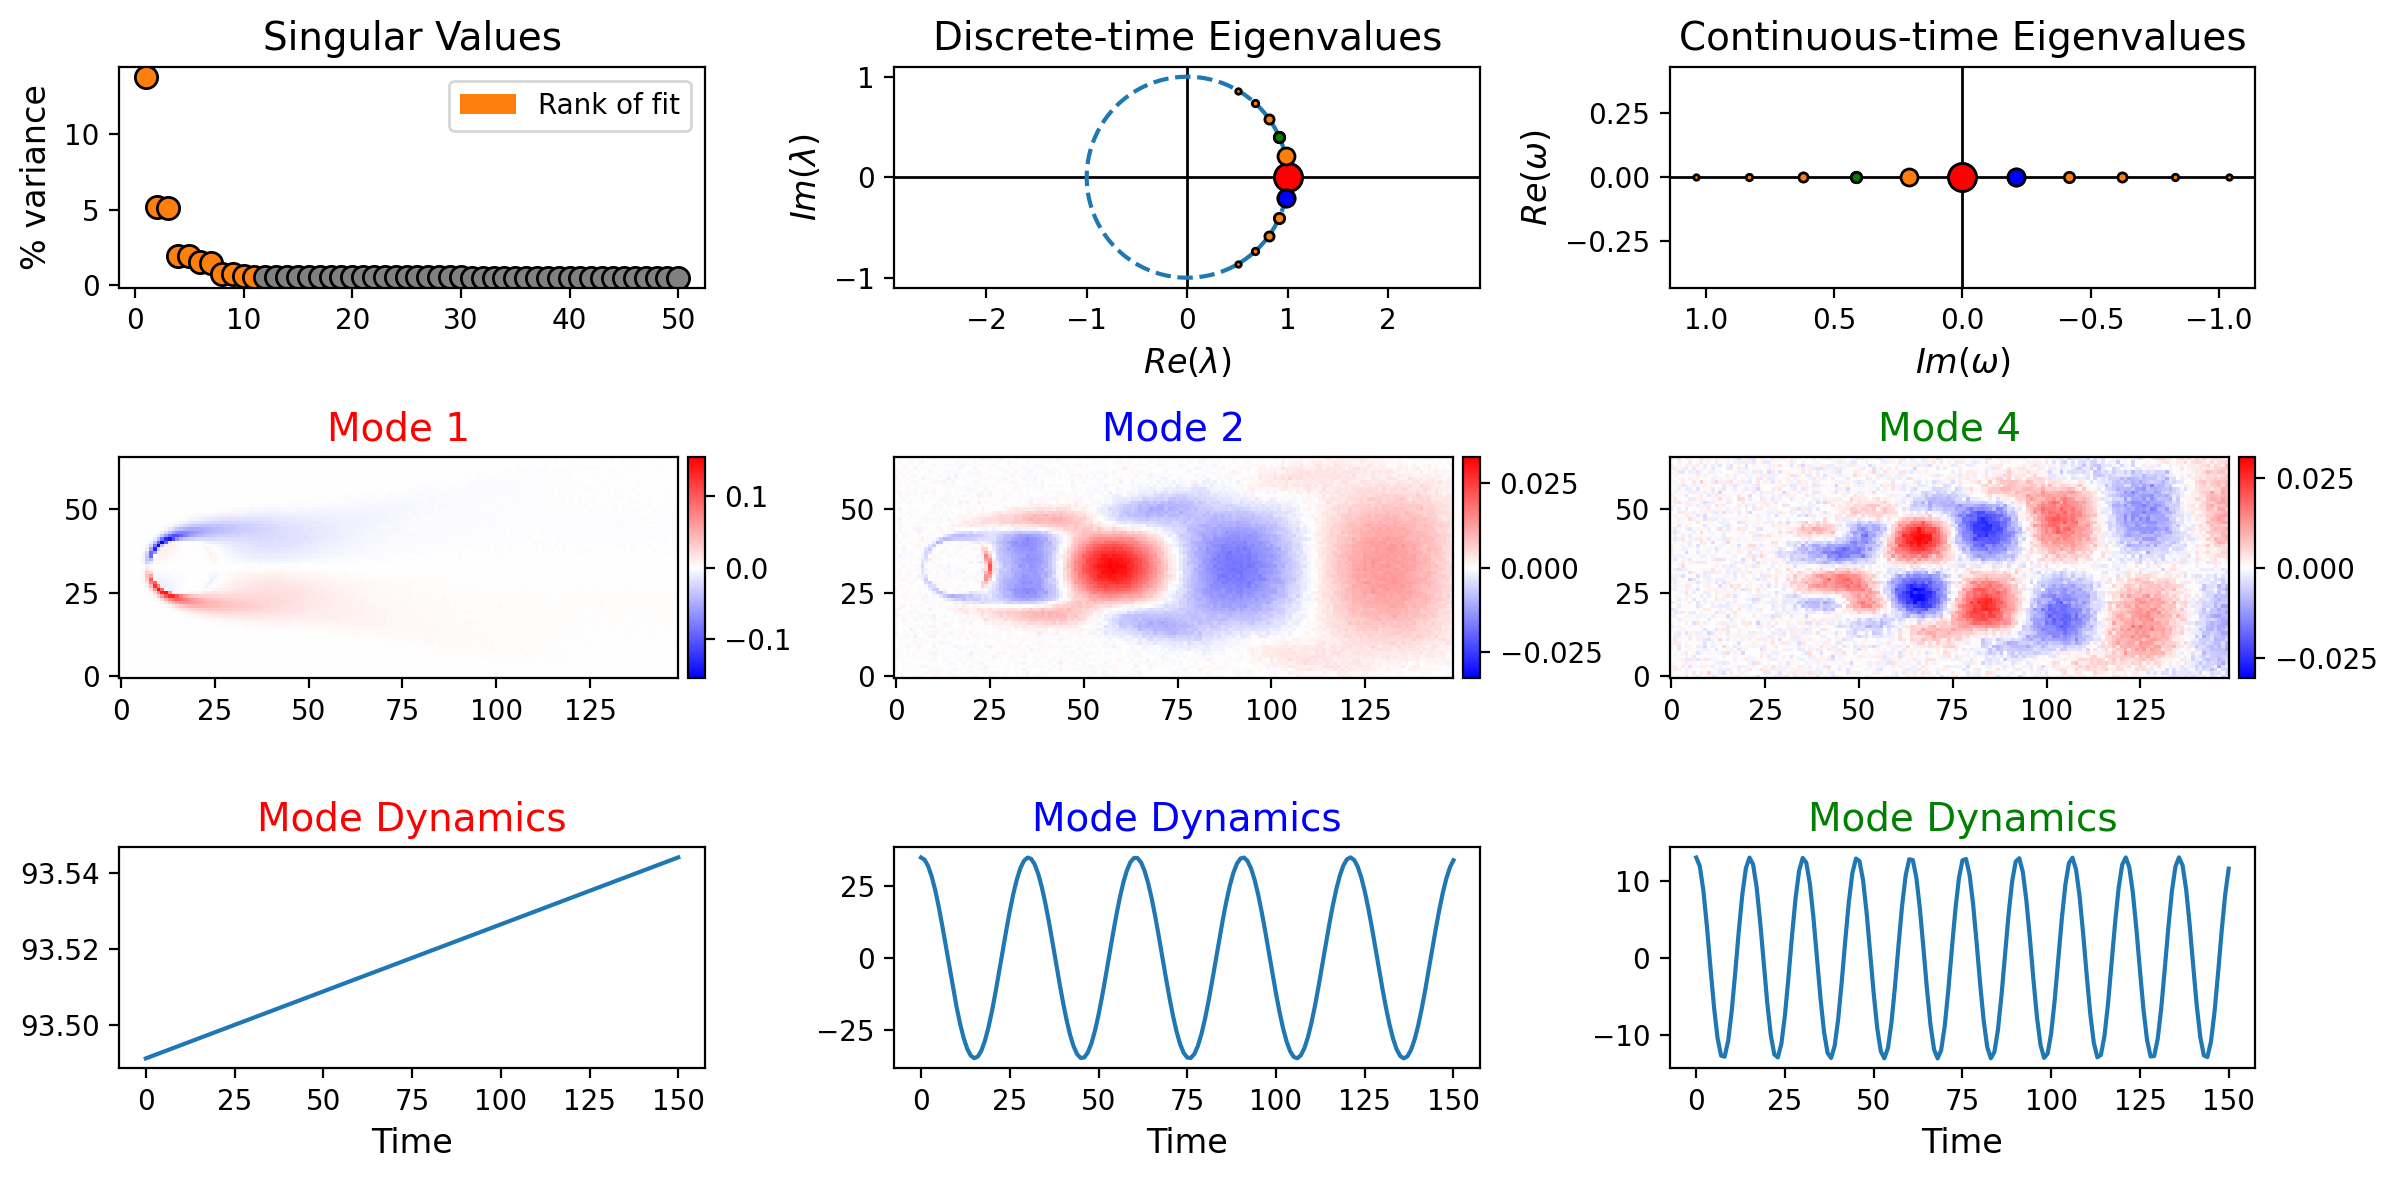

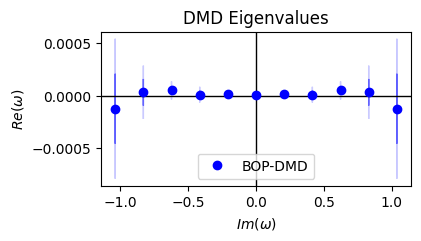

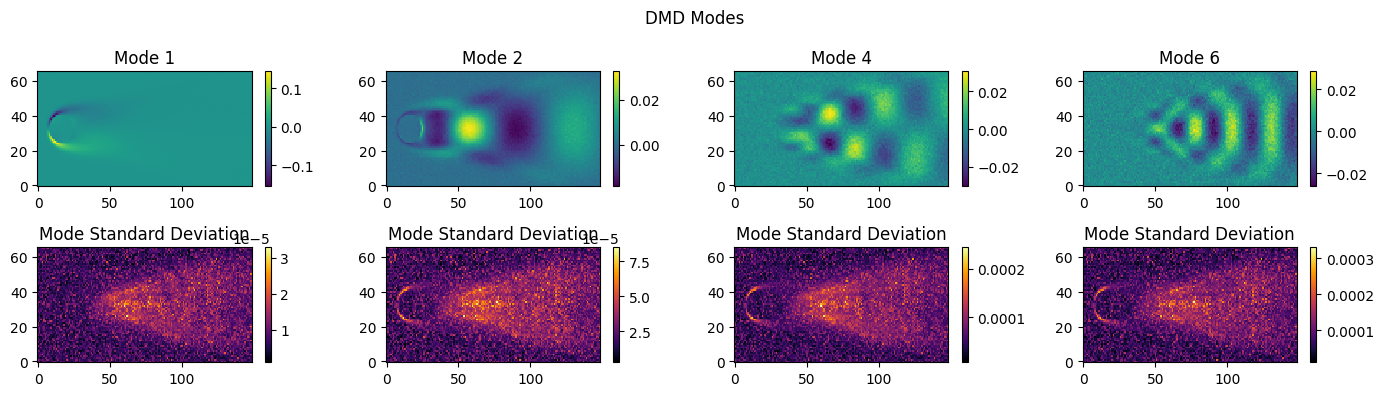

In [7]:
# Build a BOP-DMD model with 11 spatiotemporal modes, and 100 bagging trials,
# where each trial uses 80% of the total number of snapshots per trial.
# Request parallel bagging, and set the seed for reproducible output.
bopdmd = BOPDMD(
    svd_rank=11,
    num_trials=100,
    trial_size=0.8,
    parallel_bagging=True,
    seed=1234,
)

# Use the multi-processing scheduler
with dask.config.set(scheduler="processes"):
    bopdmd.fit(X, t)

plot_summary(bopdmd, **plot_summary_kwargs)

# Plot eigenvalue UQ metrics.
bopdmd.plot_eig_uq(figsize=(4, 2), flip_axes=True, draw_axes=True)

# Plot mode UQ metrics.
bopdmd.plot_mode_uq(
    figsize=(14, 4),
    plot_modes=(0, 1, 3, 5),
    modes_shape=(ny, nx),
    order="F",
)

In the example above the parallelization hasn't speeded up things. That's because we are dealing with a relatively small dataset and only requesting 100 bags, so the overhead of spinning up and communicating information between multiple processes doesn't really pay off. The example below shows improved performance when requesting 1000 bags.

In [8]:
%%time
bopdmd = BOPDMD(svd_rank=11, num_trials=1000, trial_size=0.8)
bopdmd.fit(X, t)

CPU times: user 22.5 s, sys: 1.87 s, total: 24.4 s
Wall time: 23.7 s


In [9]:
%%time
bopdmd = BOPDMD(
    svd_rank=11, num_trials=1000, trial_size=0.8, parallel_bagging=True
)

with dask.config.set(scheduler="processes"):
    bopdmd.fit(X, t)

Number of converged bags: 0 out of 1000. Consider loosening the tol requirements of the variable projection routine.
CPU times: user 3.98 s, sys: 3.46 s, total: 7.44 s
Wall time: 8.5 s


### 4. BOP-DMD with Eigenvalue Constraints
<a id='eig'></a>
Set the `eig_constraints` parameter to constrain the eigenvalue structure.
- Can be a set of preset constraints, which may be combined:
    - `"stable"` = constrain eigenvalues to the left half of the complex plane.
    - `"imag"` = constrain eigenvalues to the imaginary axis of the complex plane.
    - `"conjugate_pairs"` = eigenvalues must be present with their complex conjugate.
- Can also be a custom function that will be applied to the eigenvalues.

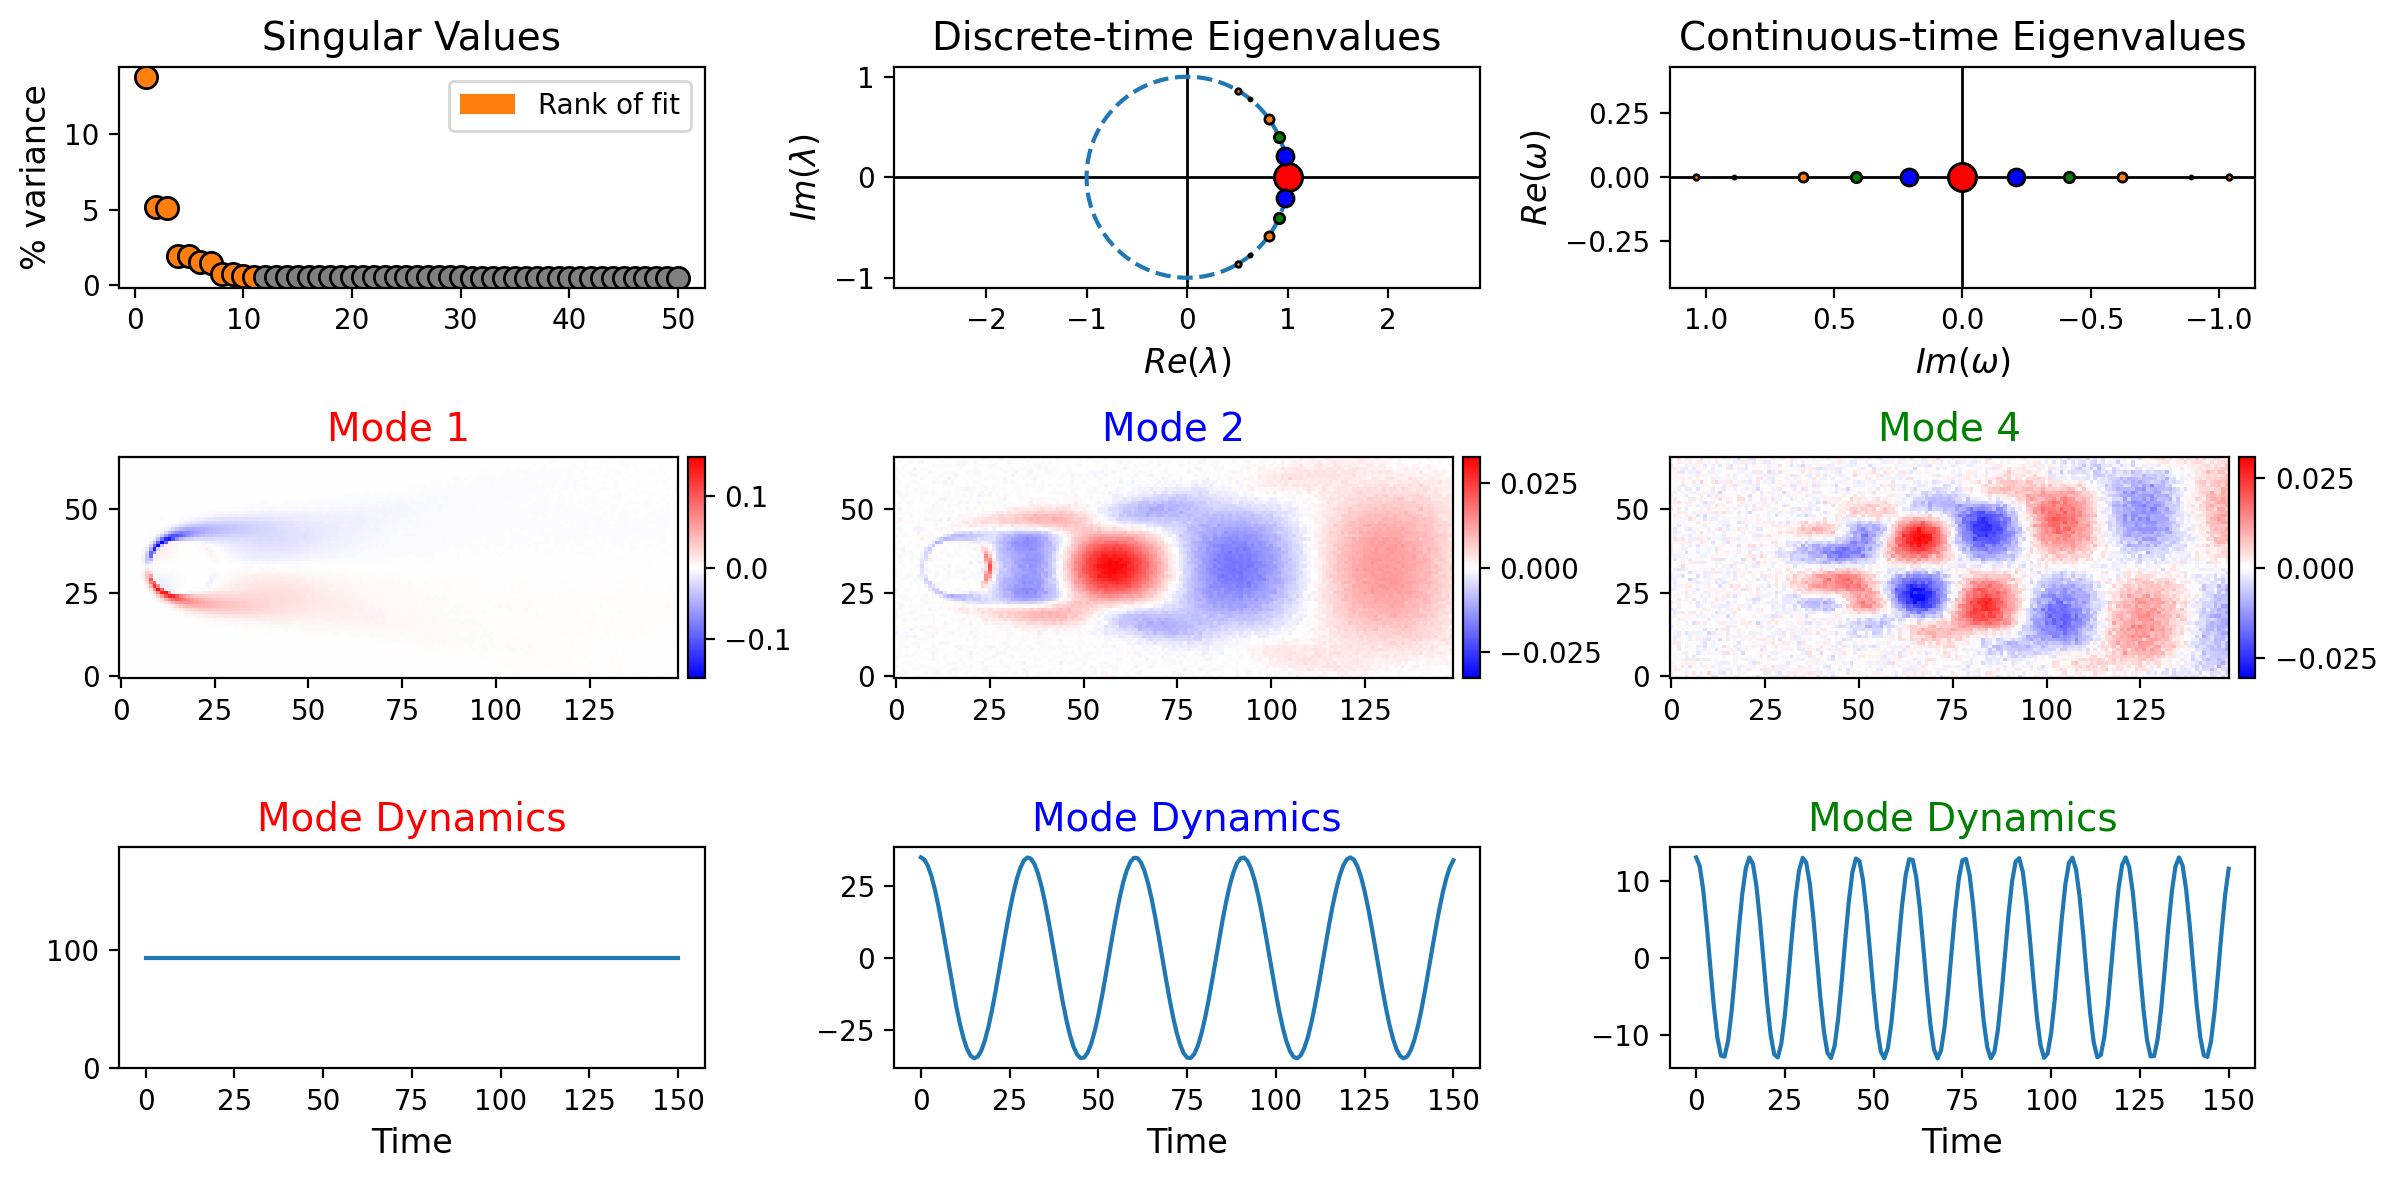

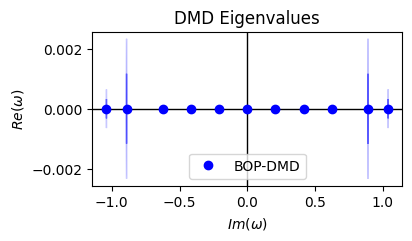

In [10]:
bopdmd = BOPDMD(
    svd_rank=11,
    num_trials=100,
    trial_size=0.8,
    # Constrain the eigenvalues to be imaginary
    # AND to always come in complex conjugate pairs.
    eig_constraints={"imag", "conjugate_pairs"},
)
bopdmd.fit(X, t)
plot_summary(bopdmd, **plot_summary_kwargs)

# View the eigenvalue UQ metrics for comparison.
bopdmd.plot_eig_uq(figsize=(4, 2), flip_axes=True, draw_axes=True)

### 5. Using Verbose Outputs
<a id='verbose'></a>
Turn on verbosity with the `varpro_opts_dict` parameter.
- Verbosity allows users to see the iterative progress of the variable projection routine.
- Verbosity also allows users to see the convergence status of the first 5 bagging trials.
- See the `BOPDMDOperator` documentation [[docs]](https://pydmd.github.io/PyDMD/bopdmd.html) for more information on all of the parameters that can be set with the `varpro_opts_dict`.

In [11]:
bopdmd = BOPDMD(
    svd_rank=11,
    num_trials=100,
    trial_size=0.8,
    eig_constraints={"imag", "conjugate_pairs"},
    # Turn on verbosity.
    varpro_opts_dict={"verbose": True},
)
bopdmd.fit(X, t)

alpha before step/n[ 0.+1.0679411j   0.+0.87423134j  0.+0.64408916j  0.+0.42196146j
  0.+0.j          0.+0.20861039j -0.-1.0679411j  -0.-0.87423134j
 -0.-0.64408916j -0.-0.20861039j -0.-0.42196146j]
alpha after step
[ 0.+1.0592104j   0.+0.87496704j  0.+0.63268703j  0.+0.416074j
  0.+0.j          0.+0.20782629j -0.-1.0592104j  -0.-0.87496704j
 -0.-0.63268703j -0.-0.20782629j -0.-0.416074j  ]
Step 1 Error 0.09326927865062162 Lambda 0.3333333333333333
alpha before step/n[ 0.+1.0592104j   0.+0.87496704j  0.+0.63268703j  0.+0.416074j
  0.+0.j          0.+0.20782629j -0.-1.0592104j  -0.-0.87496704j
 -0.-0.63268703j -0.-0.20782629j -0.-0.416074j  ]
alpha after step
[ 0.+1.0480205j   0.+0.8765196j   0.+0.62469643j  0.+0.415669j
  0.+0.j          0.+0.20782778j -0.-1.0480205j  -0.-0.8765196j
 -0.-0.62469643j -0.-0.20782778j -0.-0.415669j  ]
Step 2 Error 0.0718542617936748 Lambda 0.1111111111111111
alpha before step/n[ 0.+1.0480205j   0.+0.8765196j   0.+0.62469643j  0.+0.415669j
  0.+0.j        

### 6. Removing Bad Bags
<a id='bag-fail'></a>
Omit the results of non-converged trials by setting `remove_bad_bags=True` (defaults to `False`).
- Doing this activates the parameters `bag_warning` and `bag_maxfail`:
    - `bag_warning` = number of consecutive non-converged trials at which to warn the user. (default=100)
    - `bag_maxfail` = number of consecutive non-converged trials to tolerate before quitting. (default=200)
    - Use negative integer arguments for no warning or stopping condition.
- Whether or not a trial converges depends on the tolerance parameter, which is controlled by `tol`.
    - Set this parameter with the `varpro_opts_dict`.
    - Use verbosity to gauge what a realistic tolerance might look like for your data.
  
The behavior of `remove_bad_bags=True` is different with sequential and parallel bagging. With parallel bagging (`parallel_bagging=True`, defaults to `False`), the algorithm will attempt a maximum of `num_trials` BOP-DMD trials, and will only use the converged trials to compute statistics. If the converged trials are fewer than 50\% of `num_trials`, a warning is issued. The parameters `bag_warning` and `bag_maxfail` do not apply when `parallel_bagging=True`.

In [12]:
bopdmd = BOPDMD(
    svd_rank=11,
    num_trials=100,
    trial_size=0.8,
    eig_constraints={"imag", "conjugate_pairs"},
    # Adjust the tolerance so that convergence is more reasonable.
    varpro_opts_dict={"verbose": True, "tol": 0.12},
    # BOP-DMD will run until 100 trials converge,
    # OR until 200 consecutive trials fail to converge.
    remove_bad_bags=True,
)
bopdmd.fit(X, t)

alpha before step/n[ 0.+1.0679411j   0.+0.87423134j  0.+0.64408916j  0.+0.42196146j
  0.+0.j          0.+0.20861039j -0.-1.0679411j  -0.-0.87423134j
 -0.-0.64408916j -0.-0.20861039j -0.-0.42196146j]
alpha after step
[ 0.+1.0592104j   0.+0.87496704j  0.+0.63268703j  0.+0.416074j
  0.+0.j          0.+0.20782629j -0.-1.0592104j  -0.-0.87496704j
 -0.-0.63268703j -0.-0.20782629j -0.-0.416074j  ]
Step 1 Error 0.09326927865062162 Lambda 0.3333333333333333
Convergence reached!

Displaying the results of the next 5 trials...

Non-converged trial results will be removed...

alpha before step/n[ 0.+1.0592104j   0.+0.87496704j  0.+0.63268703j  0.+0.416074j
  0.+0.j          0.+0.20782629j -0.-1.0592104j  -0.-0.87496704j
 -0.-0.63268703j -0.-0.20782629j -0.-0.416074j  ]
alpha after step
[ 0.+1.0485651j   0.+0.87839824j  0.+0.62471324j  0.+0.41565862j
  0.+0.j          0.+0.20782273j -0.-1.0485651j  -0.-0.87839824j
 -0.-0.62471324j -0.-0.20782273j -0.-0.41565862j]
Step 1 Error 0.07091801498253276 La

### 7. Applying Data Preprocessors
<a id='preprocess'></a>
`BOPDMD` models can be used with tools from the `pydmd.preprocessing` suite.
- Simply wrap your `BOPDMD` model with the desired preprocessing tool.
- Calls to `fit` will now require setting the time vector `t` with a keyword argument.

alpha before step/n[-0.-8.7440389e-01j  0.+8.7440389e-01j -0.-6.4446163e-01j
  0.+6.4446163e-01j -0.-4.2195317e-01j -0.-2.0858943e-01j
  0.+4.2195317e-01j -0.-1.6914480e-16j  0.+1.6914480e-16j
  0.+2.0858943e-01j]
alpha after step
[-0.-8.7534773e-01j  0.+8.7534773e-01j -0.-6.3309509e-01j
  0.+6.3309509e-01j -0.-4.1607535e-01j -0.-2.0782600e-01j
  0.+4.1607535e-01j  0.+2.4272466e-12j -0.-2.4272466e-12j
  0.+2.0782600e-01j]
Step 1 Error 0.09295703340436305 Lambda 0.3333333333333333
Convergence reached!

Displaying the results of the next 5 trials...

Non-converged trial results will be removed...

alpha before step/n[-0.-8.7534773e-01j  0.+8.7534773e-01j -0.-6.3309509e-01j
  0.+6.3309509e-01j -0.-4.1607535e-01j -0.-2.0782600e-01j
  0.+4.1607535e-01j  0.+2.4272466e-12j -0.-2.4272466e-12j
  0.+2.0782600e-01j]
alpha after step
[-0.-8.7791628e-01j  0.+8.7791628e-01j -0.-6.2504536e-01j
  0.+6.2504536e-01j -0.-4.1562626e-01j -0.-2.0784374e-01j
  0.+4.1562626e-01j  0.+2.3237892e-04j -0.-2.32378

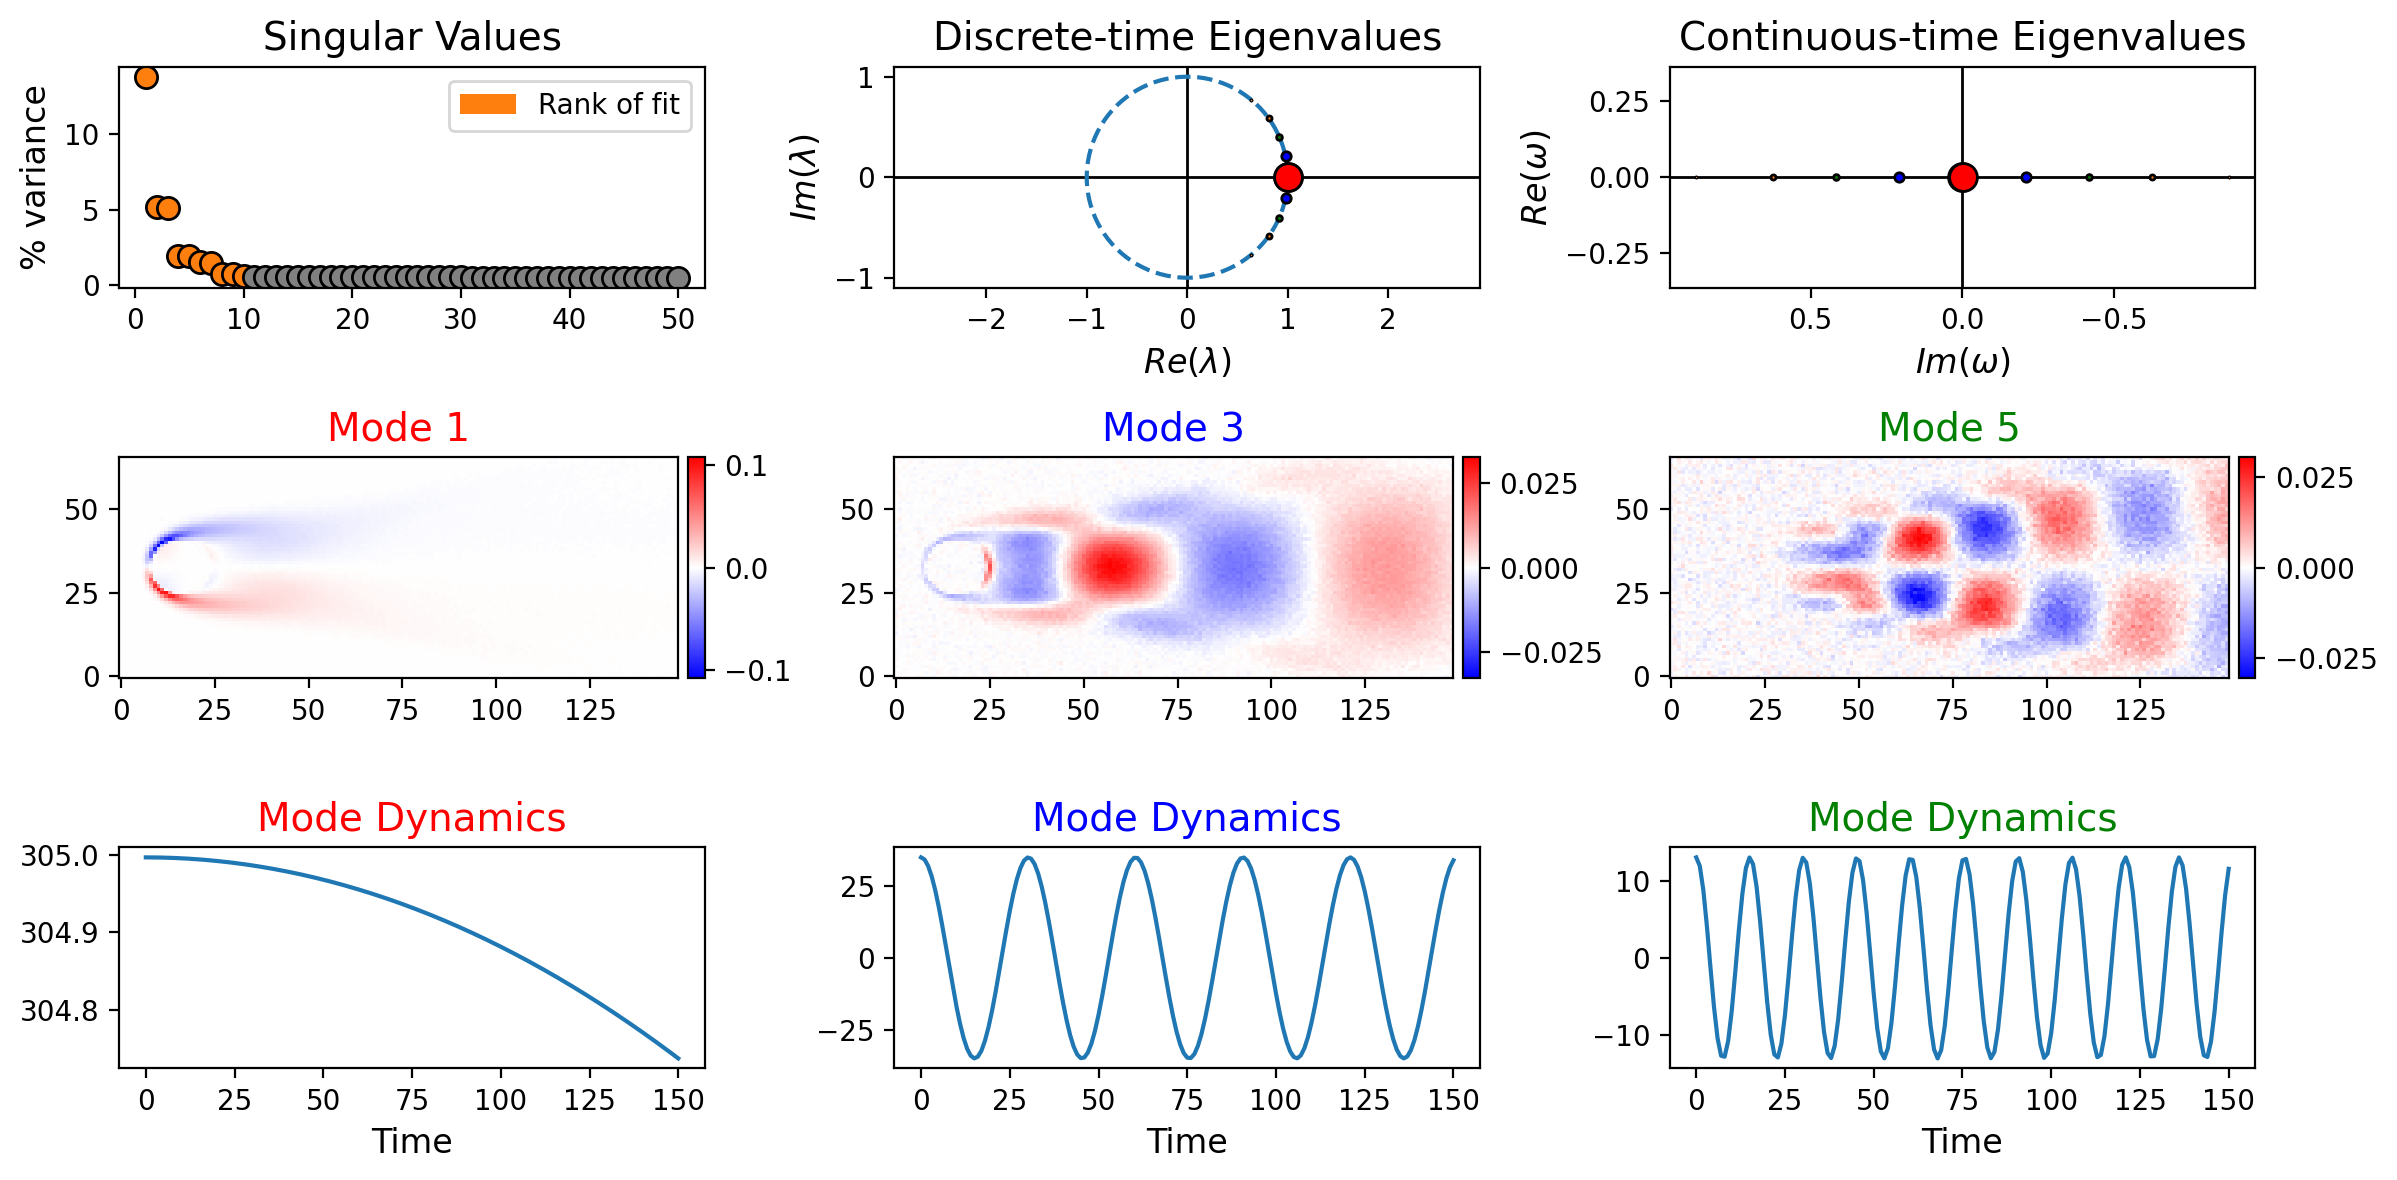

In [13]:
# BOP-DMD with zero mean centered data.
bopdmd = BOPDMD(
    svd_rank=10,  # Use an even rank due to zero mean preprocessing.
    num_trials=100,
    trial_size=0.8,
    eig_constraints={"imag", "conjugate_pairs"},
    varpro_opts_dict={"verbose": True, "tol": 0.2},
    remove_bad_bags=True,
)
bopdmd = zero_mean_preprocessing(bopdmd)
bopdmd.fit(X, t=t)

# Same plot_summary call, but plot modes 1, 3, and 5.
plot_summary_kwargs["index_modes"] = (0, 2, 4)
plot_summary(bopdmd, **plot_summary_kwargs)